<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/Simplex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization using the Simplex method

In this example, we will use the Simplex method to optimize a multivariable problem.
Consider an enzyme reactor, where a certain chemical substance is produced. Through a screening experimental design, three variables were found to significantly affect the yield. The task nos is to use this information and optimize the yield of the product. The variables that had the highest effects in the screening tests are ‘Temperature’, ’pH’, and ’Amount of enzyme’. The range of the settings for these variables are:

Temp = 20-45 ($^o$C) pH = 5-9 Amount = 5-25 (mg)



The first step is as usual to load the libraries we want to use.

In [ ]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd

The yield is calcualted using a function (experiment) taking the variables as input in the form of a list (X). The output from this function is the yield (response). This is given below:  

In [ ]:
def experiment(X):
  Xspan=[25, 4, 20]
  Xmin=[20, 5, 5]
  Xscale=[]
  for a, b,c in zip(X, Xmin,Xspan):
    Xscale.append((a-b)/c)

  koeff=[[0.643, -0.686, -0.341], [0.704, 0.704, -0.087], [0.3, -0.184, 0.936]]
  koeff=np.array(koeff)

  max1=[0.21, 0.77, 0.68]
  cent1=[]
  for a,b in zip(Xscale, max1):
    cent1.append(a-b)

  koord1=np.matmul(koeff.T, cent1)
  max2=[0.73, 0.42, 0.19]
  cent2=[]
  for a, b in zip(Xscale, max2):
    cent2.append(a-b)

  Resp1=8/(0.1+2*koord1[0]*koord1[0]+0.5*koord1[1]*koord1[1]+0.9*koord1[2]*koord1[2])
  Resp2=1/(0.05+10*(np.sum(np.square(cent2), axis=0)))
  Resp=(15+Resp1+Resp2)+0.1*(rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand())
  return Resp


Let's first try 10 random experiments, which perhaps would be the way to solve this problem for the "unexperienced" data scientist :).

In [ ]:
XT=np.random.uniform(20,45,10)
XpH=np.random.uniform(5,9,10)
XA=np.random.uniform(5,25,10)
X=[XT, XpH, XA]

Response=[]
for i in range(len(X[0][:])):
  Xexp=[X[0][i], X[1][i],X[2][i]]
  Resp=experiment(Xexp)
  Response.append(Resp)

print(Response)

[np.float64(29.214744983212004), np.float64(47.7031734083877), np.float64(26.321944860694035), np.float64(25.24792574020101), np.float64(35.6632483910589), np.float64(24.595831499273135), np.float64(23.270731179745717), np.float64(27.712337431247718), np.float64(48.63158908908045), np.float64(29.69516087124568)]


We can plot the yield as function of position in the varius input parameters:

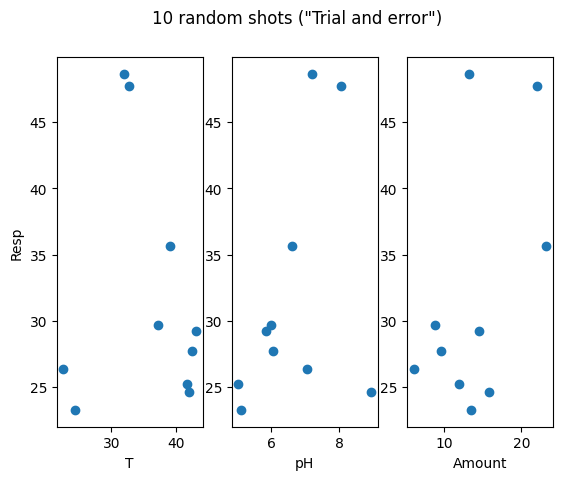

In [ ]:
fig, axs = plt.subplots(1,3)
fig.suptitle('10 random shots ("Trial and error")')
axs[0].scatter(X[:][0], Response)
axs[1].scatter(X[:][1], Response)
axs[2].scatter(X[:][2], Response)

axs[0].set_xlabel('T')
axs[1].set_xlabel('pH')
axs[2].set_xlabel('Amount')
axs[0].set_ylabel('Resp')

fig.subplots_adjust(hspace=0.5)

and examine the results... We see that one of the experiments seems to come out with a very high yield. However, this were pure luck... Let's do it in a more systematic way using the simplex method.

# Simplex optimization
The simplex method is a strategy for navigating through the variable space, heading for an optimum. In the three-dimensional space a simplex has corners or vertices V1 through V4 (one more than the
number of experimental variables) and the response is obtained for all these experimental conditions.

The simplex optimization strategy is to move the simplex by replacing the worst point (with respect to the optimization goal) by reflecting it through the mean value of the others. Then sort the vertices with
respect to the responses, so that V1 is the best and V4 is the worst point. Calculate a new point, V5 according to:
$$
\begin{equation}
V5 = (V1+V2+V3)/3 - ( V4 – (V1+V2+V3)/3 ) = 2*(V1+V2+V3)/3 - V4
\end{equation}
$$

Obtain the response for **V5** and replace **V4** with **V5**, so that **V4** now stands for the new vertex with the new response value. The simplex should now have moved towards the optimum (although maybe not
the straight way...) and the procedure is repeated. The iteration involves the following steps:

1. Sort the simplex points (**V1** through **V4**) according to the responses and calculate **V5**
2. Perform the experiment according to **V5**
3. Replace the worst point (V4) with the new point (**V5**)

Let see how we can do this in python...

First, let's set start with three experiements, choosing three settings for our variables.

In [ ]:
XT=[20.0, 23.0, 21.5]
XpH=[5.0, 5.0, 5.4]
XA=[15.0, 15.0, 15.0]


add add the 4th point

In [ ]:
XT.append(21.5)
XpH.append(5.1)
XA.append(16.6)

X=[XT, XpH, XA]

and then perform the experiments:

In [ ]:
Response=[]
for i in range(len(X[0][:])):
  Xexp=[X[0][i], X[1][i],X[2][i]]
  Resp=experiment(Xexp)
  Response.append(Resp)

Resp=pd.DataFrame({'T':X[0][:],'pH':X[1][:], 'Amount':X[2][:],'Response':Response})
Resp

,T,pH,Amount,Response
0,20.0,5.0,15.0,21.648309
1,23.0,5.0,15.0,22.683776
2,21.5,5.4,15.0,23.917367
3,21.5,5.1,16.6,22.915859


The points in 3D looks like this:

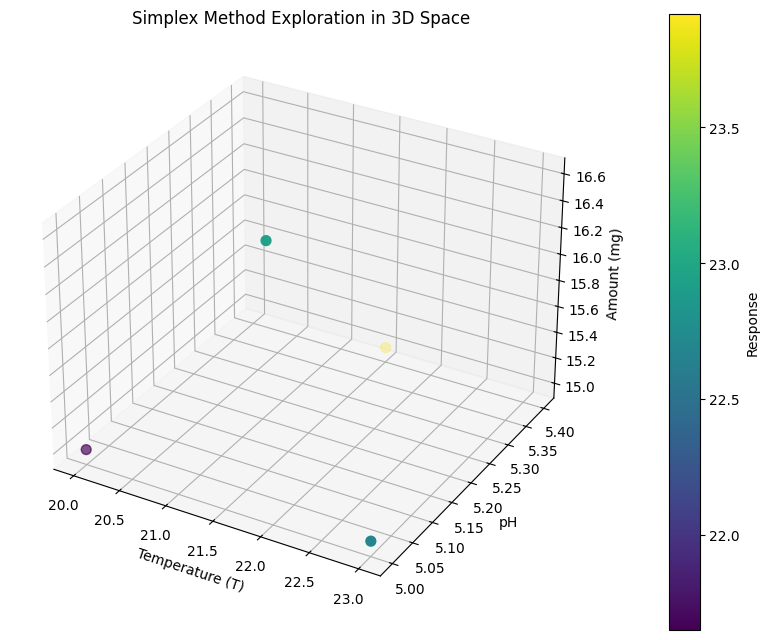

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Resp['T'], Resp['pH'], Resp['Amount'], c=Resp['Response'], cmap='viridis', s=50)

ax.set_xlabel('Temperature (T)')
ax.set_ylabel('pH')
ax.set_zlabel('Amount (mg)')
ax.set_title('Simplex Method Exploration in 3D Space')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Response')

plt.show()

again, we can plot the data to visually analyse the outcome of our experiments:

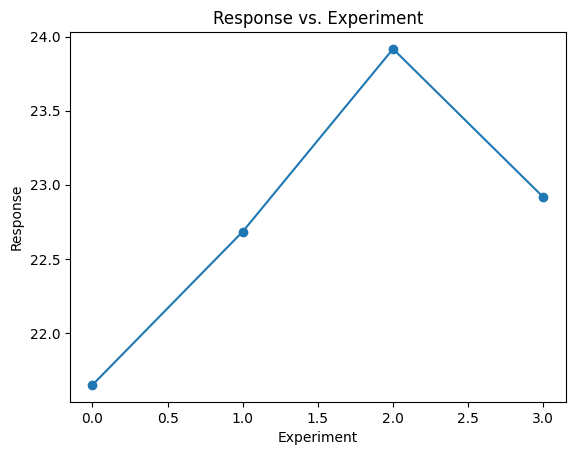

In [ ]:
Resp['Response'].plot(marker='o')
plt.xlabel('Experiment')
plt.ylabel('Response')
plt.title('Response vs. Experiment')
plt.show()

The next step is to sort the data:

In [ ]:
Resp = Resp.sort_values(by='Response', ascending=True)

In [ ]:
Resp['T'].iloc[-1]

np.float64(21.5)

and from this sorted table compute next point (**V5**)

In [ ]:
V1 = np.array([Resp['T'].iloc[-1], Resp['pH'].iloc[-1], Resp['Amount'].iloc[-1]])
V2 = np.array([Resp['T'].iloc[-2], Resp['pH'].iloc[-2], Resp['Amount'].iloc[-2]])
V3 = np.array([Resp['T'].iloc[-3], Resp['pH'].iloc[-3], Resp['Amount'].iloc[-3]])
V4 = np.array([Resp['T'].iloc[-4], Resp['pH'].iloc[-4], Resp['Amount'].iloc[-4]])

V5 = 2*(V1 + V2 + V3)/3-V4

V5

array([24.        ,  5.33333333, 16.06666667])

the vector **V5** contain the variables that should be used in our next experiment. Let's perform the experiment and add the response to our original response table:

In [ ]:
Xexp=[V5[0], V5[1],V5[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V5[0],'pH':V5[1], 'Amount':V5[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp

,T,pH,Amount,Response
0,20.0,5.000000,15.000000,21.648309
1,23.0,5.000000,15.000000,22.683776
2,21.5,5.100000,16.600000,22.915859
3,21.5,5.400000,15.000000,23.917367
4,24.0,5.333333,16.066667,24.947722


The point we added can be shown in 3D:

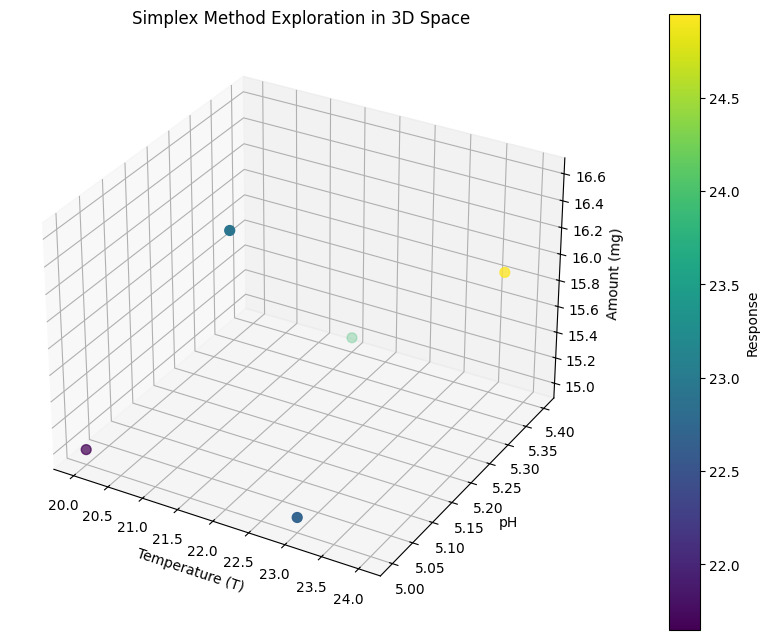

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Resp['T'], Resp['pH'], Resp['Amount'], c=Resp['Response'], cmap='viridis', s=50)

ax.set_xlabel('Temperature (T)')
ax.set_ylabel('pH')
ax.set_zlabel('Amount (mg)')
ax.set_title('Simplex Method Exploration in 3D Space')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Response')

plt.show()

As seen, we now got an increased yield. Again, we can plot the yield:  

<Axes: >

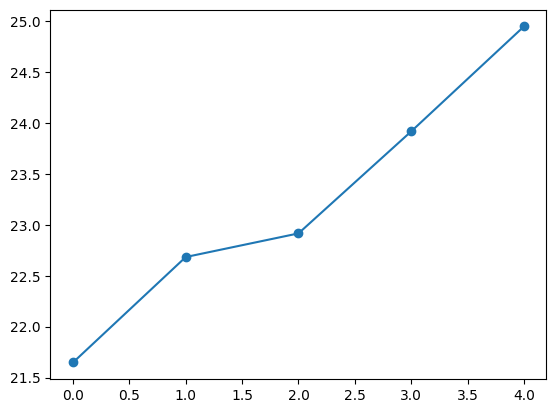

In [ ]:
Resp['Response'].plot(marker='o')

And sort the data:

In [ ]:
Resp = Resp.sort_values(by='Response', ascending=True)

and compute the new experiement to perform:

In [ ]:
V1 = np.array([Resp['T'].iloc[-1], Resp['pH'].iloc[-1], Resp['Amount'].iloc[-1]])
V2 = np.array([Resp['T'].iloc[-2], Resp['pH'].iloc[-2], Resp['Amount'].iloc[-2]])
V3 = np.array([Resp['T'].iloc[-3], Resp['pH'].iloc[-3], Resp['Amount'].iloc[-3]])
V4 = np.array([Resp['T'].iloc[-4], Resp['pH'].iloc[-4], Resp['Amount'].iloc[-4]])

V6 = 2*(V1 + V2 + V3)/3-V4

V6

array([21.66666667,  5.55555556, 16.77777778])

and perform the new experiment and add it to our table:

In [ ]:
Xexp=[V6[0], V6[1],V6[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V6[0],'pH':V6[1], 'Amount':V6[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp

,T,pH,Amount,Response
0,20.000000,5.000000,15.000000,21.648309
1,23.000000,5.000000,15.000000,22.683776
2,21.500000,5.100000,16.600000,22.915859
3,21.500000,5.400000,15.000000,23.917367
4,24.000000,5.333333,16.066667,24.947722
5,21.666667,5.555556,16.777778,25.258142


and the plot:

<Axes: >

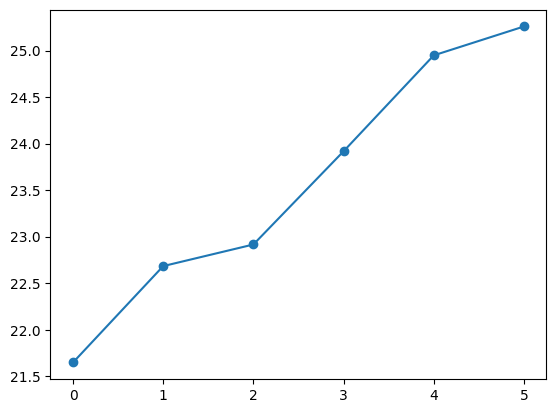

In [ ]:
Resp['Response'].plot(marker='o')

let's continue:

In [ ]:
Resp = Resp.sort_values(by='Response', ascending=True)

In [ ]:
V1 = np.array([Resp['T'].iloc[-1], Resp['pH'].iloc[-1], Resp['Amount'].iloc[-1]])
V2 = np.array([Resp['T'].iloc[-2], Resp['pH'].iloc[-2], Resp['Amount'].iloc[-2]])
V3 = np.array([Resp['T'].iloc[-3], Resp['pH'].iloc[-3], Resp['Amount'].iloc[-3]])
V4 = np.array([Resp['T'].iloc[-4], Resp['pH'].iloc[-4], Resp['Amount'].iloc[-4]])

V7 = 2*(V1 + V2 + V3)/3-V4

V7

array([23.27777778,  5.75925926, 15.2962963 ])

In [ ]:
Xexp=[V7[0], V7[1],V7[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V7[0],'pH':V7[1], 'Amount':V7[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp

,T,pH,Amount,Response
0,20.000000,5.000000,15.000000,21.648309
1,23.000000,5.000000,15.000000,22.683776
2,21.500000,5.100000,16.600000,22.915859
3,21.500000,5.400000,15.000000,23.917367
4,24.000000,5.333333,16.066667,24.947722
5,21.666667,5.555556,16.777778,25.258142
6,23.277778,5.759259,15.296296,27.204905


<Axes: >

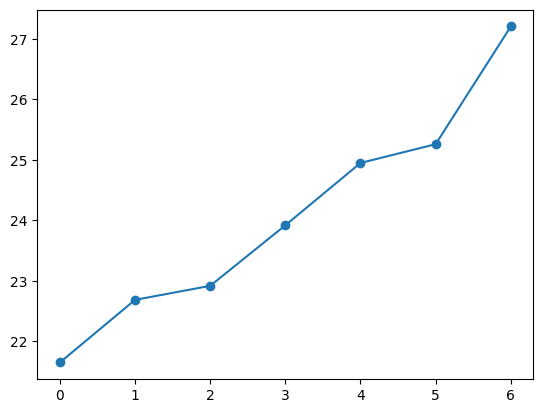

In [ ]:
Resp['Response'].plot(marker='o')

and again

In [ ]:
Resp = Resp.sort_values(by='Response', ascending=True)
V1 = np.array([Resp['T'].iloc[-1], Resp['pH'].iloc[-1], Resp['Amount'].iloc[-1]])
V2 = np.array([Resp['T'].iloc[-2], Resp['pH'].iloc[-2], Resp['Amount'].iloc[-2]])
V3 = np.array([Resp['T'].iloc[-3], Resp['pH'].iloc[-3], Resp['Amount'].iloc[-3]])
V4 = np.array([Resp['T'].iloc[-4], Resp['pH'].iloc[-4], Resp['Amount'].iloc[-4]])

V8 = 2*(V1 + V2 + V3)/3-V4

V8

array([24.46296296,  5.69876543, 17.09382716])

<Axes: >

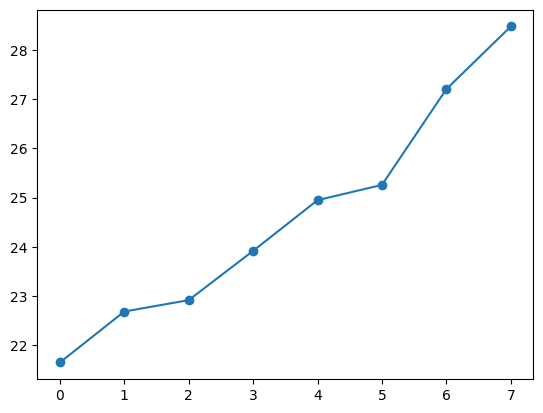

In [ ]:
Xexp=[V8[0], V8[1],V8[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V8[0],'pH':V8[1], 'Amount':V8[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp
Resp['Response'].plot(marker='o')

We still see an increase, let us automatize it further:

In [ ]:
V=[]
for i in range(0,10):
   Resp = Resp.sort_values(by='Response', ascending=True)
   V1 = np.array([Resp['T'].iloc[-1], Resp['pH'].iloc[-1], Resp['Amount'].iloc[-1]])
   V2 = np.array([Resp['T'].iloc[-2], Resp['pH'].iloc[-2], Resp['Amount'].iloc[-2]])
   V3 = np.array([Resp['T'].iloc[-3], Resp['pH'].iloc[-3], Resp['Amount'].iloc[-3]])
   V4 = np.array([Resp['T'].iloc[-4], Resp['pH'].iloc[-4], Resp['Amount'].iloc[-4]])

   V.append(2*(V1 + V2 + V3)/3-V4)
   Xexp=[V[i][0], V[i][1],V[i][2]]
   newexp=experiment(Xexp)
   newresp=(newexp)
   newresponse={'T':V[i][0],'pH':V[i][1], 'Amount':V[i][2],'Response':newresp}
   Resp = Resp._append(newresponse, ignore_index=True)


Resp


,T,pH,Amount,Response
0,20.000000,5.000000,15.000000,21.648309
1,23.000000,5.000000,15.000000,22.683776
2,21.500000,5.100000,16.600000,22.915859
3,21.500000,5.400000,15.000000,23.917367
4,24.000000,5.333333,16.066667,24.947722
5,21.666667,5.555556,16.777778,25.258142
6,23.277778,5.759259,15.296296,27.204905
7,24.462963,5.698765,17.093827,28.478266
8,22.271605,6.009053,16.711934,29.220795
9,25.008230,6.089163,15.956927,32.167240


<Axes: >

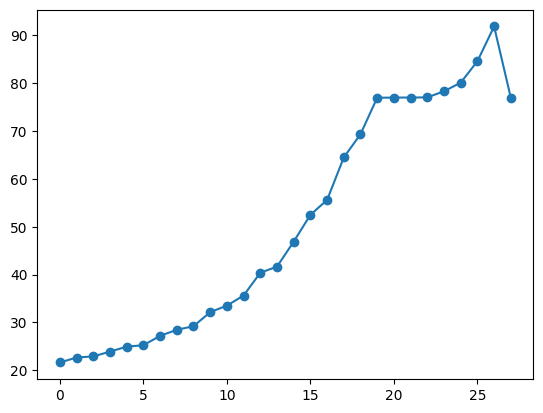

In [ ]:
Resp['Response'].plot(marker='o')

After 28 experiments, we seem to have reached a plateou with the simplex method. We found a maximum response of 91.838494 using T=26.884802,	pH=7.870758 and	A=18.223462.
Let's look at each of the parameters vs response.

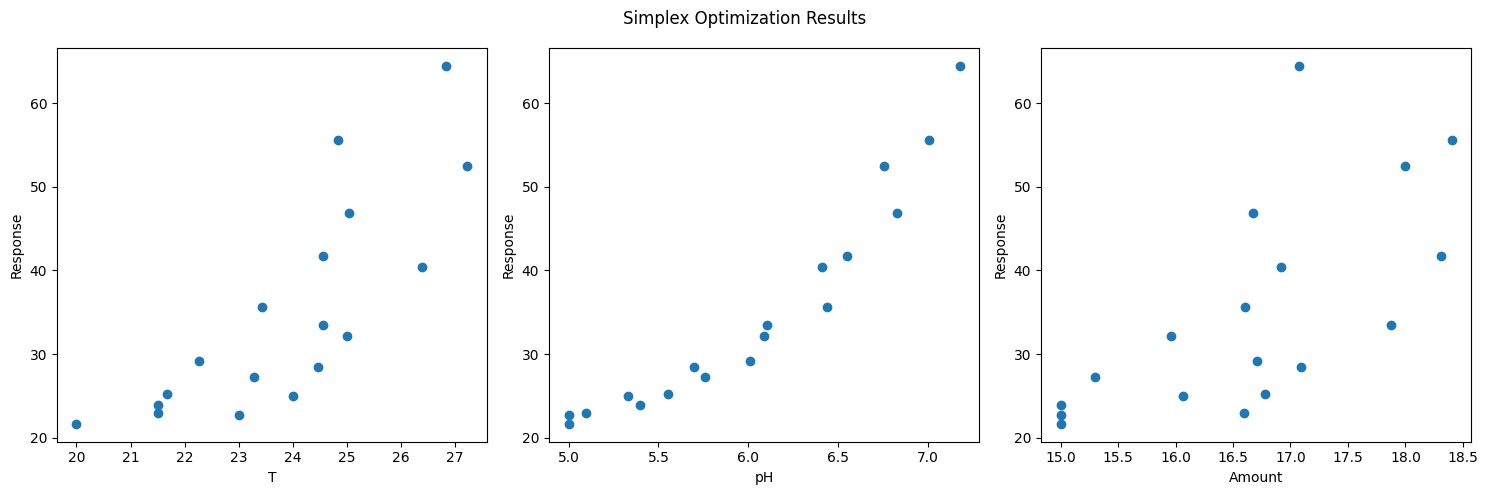

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Simplex Optimization Results')

axs[0].scatter(Resp['T'], Resp['Response'])
axs[0].set_xlabel('T')
axs[0].set_ylabel('Response')

axs[1].scatter(Resp['pH'], Resp['Response'])
axs[1].set_xlabel('pH')
axs[1].set_ylabel('Response')

axs[2].scatter(Resp['Amount'], Resp['Response'])
axs[2].set_xlabel('Amount')
axs[2].set_ylabel('Response')

plt.tight_layout()
plt.show()

Looking at the scatter plots:

- **Temperature (T) vs. Response:** The plot shows a general trend of increasing response as temperature increases. It seems the simplex method explored higher temperatures and found better yields in that region.
- **pH vs. Response:** This plot also suggests an increasing trend in response with increasing pH within the explored range. The highest responses appear to be at higher pH values.
- **Amount (of enzyme) vs. Response:** The relationship between the amount of enzyme and response is less clear from this plot. There might be a slight positive trend initially, but the data points are more scattered, making it harder to discern a strong linear relationship within the explored range.

Overall, the simplex method seems to have moved towards higher temperatures and pH values, which resulted in increased yield. The effect of the amount of enzyme is less pronounced based on these plots.


 Can we do it with fewer experiments? Can we find a better maximum?